In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rqalpha.apis import *
from rqfactor.notebook.exposure import factor_analysis
from rqoptimizer import *
from rqoptimizer.utils import *
from rqdatac import *
from rqalpha_plus import run_func
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from functools import wraps
warnings.filterwarnings("ignore")
rqdatac.init()

Cannot initialize filter sz3: File not found


In [3]:
df_etf = pd.read_excel('etf_code.xlsx')
etf_code = df_etf.code.values.tolist()
etf_code = [str(code) for code in etf_code]
df_etf = all_instruments(type='ETF' , market = 'cn')
df_etf = df_etf[df_etf.trading_code.isin(etf_code)]

In [5]:
symbol = df_etf.order_book_id.values.tolist()
start = "2020-01-01"
end = "2023-12-31"
frequency = "1d"

In [7]:
df_price_entry = get_price(symbol, start, end, frequency)[['close']].unstack(level = 0)
df_price_entry.columns = df_price_entry.columns.droplevel(0)
frequency_h = '60m'
df_price_exit = get_price(symbol, start, end, frequency_h)[['close']].unstack(level = 0)
df_price_exit.columns = df_price_exit.columns.droplevel(0)

<Axes: xlabel='datetime'>

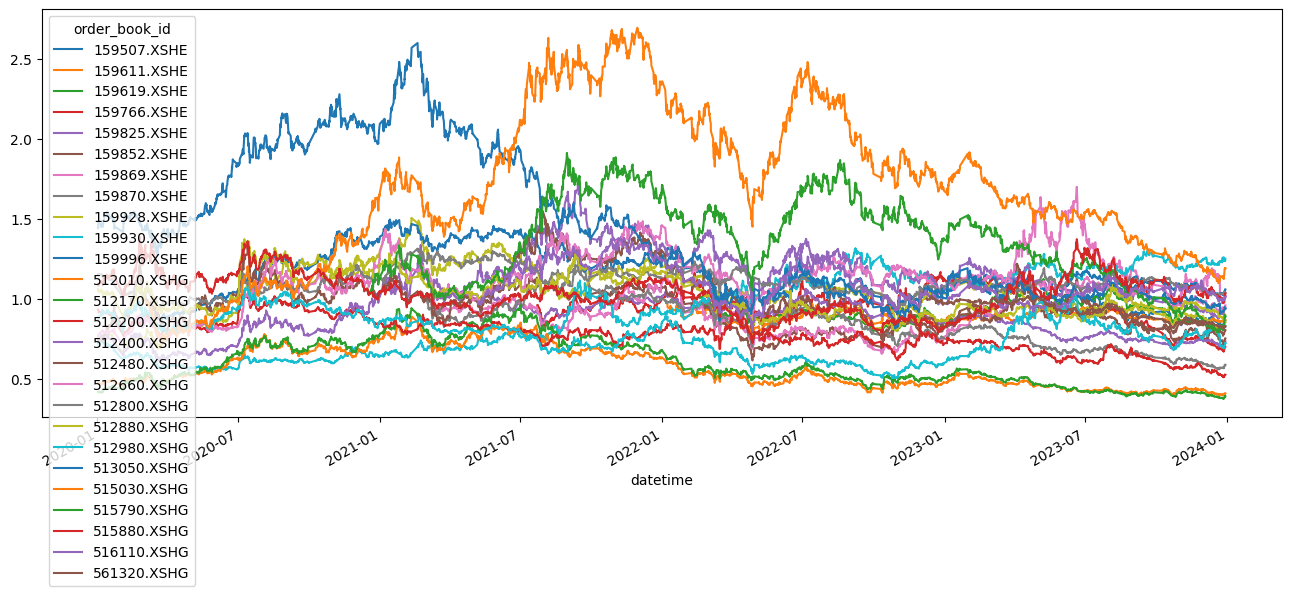

In [64]:
df_price_exit.plot(figsize = (16,6))

2020-05-29 00:00:00: 买入 512660.XSHG, 价格 0.81, 数量 6100
2020-06-16 00:00:00: 买入 512800.XSHG, 价格 0.987, 数量 5100
2020-07-10 10:30:00: 卖出 512660.XSHG, 价格 1.015, 数量 6100
2020-07-10 10:30:00: 卖出 512800.XSHG, 价格 1.115, 数量 5100
2020-09-08 00:00:00: 买入 159930.XSHE, 价格 0.615, 数量 9600
2020-09-08 00:00:00: 买入 159958.XSHE, 价格 1.5419999999999998, 数量 3800
2020-09-09 10:30:00: 卖出 159958.XSHE, 价格 1.472, 数量 3800
2020-09-11 10:30:00: 卖出 159930.XSHE, 价格 0.602, 数量 9600
2020-09-15 00:00:00: 买入 512400.XSHG, 价格 0.8320000000000001, 数量 6900
2020-09-15 00:00:00: 买入 512800.XSHG, 价格 1.07, 数量 5300
2020-09-17 10:30:00: 卖出 512400.XSHG, 价格 0.812, 数量 6900
2020-09-18 00:00:00: 买入 159930.XSHE, 价格 0.624, 数量 9100
2020-09-23 10:30:00: 卖出 159930.XSHE, 价格 0.611, 数量 9100
2020-09-29 14:00:00: 卖出 512800.XSHG, 价格 1.046, 数量 5300
2020-10-09 00:00:00: 买入 159996.XSHE, 价格 1.2209999999999999, 数量 4500
2020-10-09 00:00:00: 买入 515210.XSHG, 价格 1.0833, 数量 5200
2020-10-23 15:00:00: 卖出 159996.XSHE, 价格 1.247, 数量 4500
2020-11-23 00:00:00: 买入 159

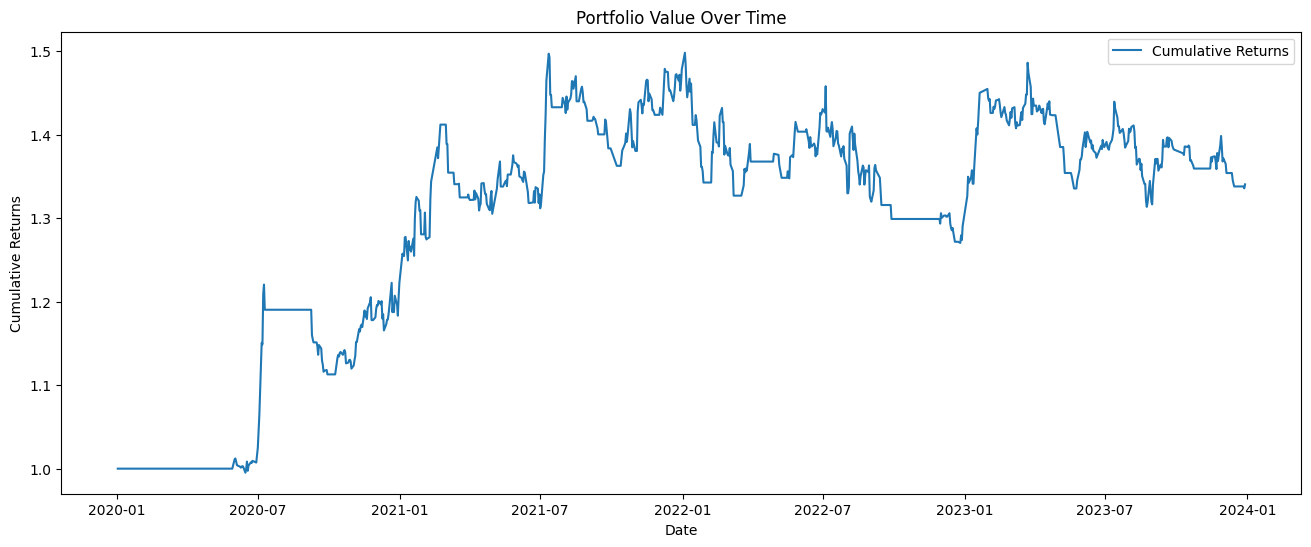

初始资金: 10000
最终资金: 13404.929999999982
年化收益率: 7.85%
最大回撤: -15.21%
未考虑无风险利率的夏普比率: 0.55
交易次数: 210


In [10]:
df = df_price_entry.copy()
count = 0
initial_capital = 10000
positions = 2
slippage_and_fees = 0.00  # 滑点
portfolio_value_tracker = []

capital = initial_capital
cash = initial_capital
etf_value = 0
holdings = {etf: 0 for etf in df.columns} 
peak = {etf: 0 for etf in df.columns}

def check_buy_signals(etf, price_data_daily, current_date, start_date):
    if len(price_data_daily) < 60 or current_date < start_date + pd.Timedelta(days=60):
        return False
    ma50 = price_data_daily[-60:].mean()
    yesterday_close = price_data_daily[-2]
    today_close = price_data_daily[-1]
    slope_positive = np.polyfit(range(60), price_data_daily[-60:], 1)[0] > 0
    if yesterday_close < ma50 and today_close >= ma50 and slope_positive:
        return True
    
    # if yesterday_close < ma50 and today_close >= ma50:
    #     return True
    return False

def buy(etf, price, date):
    global capital, cash, etf_value, holdings, count
    if not np.isnan(price) and holdings[etf] == 0:
        num_held_etfs = sum(1 for h in holdings.values() if h > 0)
        if num_held_etfs < positions:
            investable_cash = cash / (positions - num_held_etfs)
            etf_amount = int(investable_cash * (1 - slippage_and_fees) / price) // 100 * 100
            holdings[etf] = etf_amount
            cash -= etf_amount * price  
            peak[etf] = price * 1.04
            print(f"{date}: 买入 {etf}, 价格 {price}, 数量 {etf_amount}")
            count += 1

def check_stop_conditions(etf, price):
    if holdings[etf] <= 0:
        return False
    if price < peak[etf] / 1.04 * 0.98:
        return True
    if price >= peak[etf]:  
        peak[etf] = price * 1.04  
    if price < peak[etf] / 1.04 * 0.98:  
        return True
    return False


def sell(etf, price, date):
    global capital, cash, etf_value, holdings,count
    if not np.isnan(price) and holdings[etf] > 0:
        proceeds = holdings[etf] * price * (1 - slippage_and_fees)
        cash += proceeds 
        etf_value -= holdings[etf] * price
        print(f"{date}: 卖出 {etf}, 价格 {price}, 数量 {holdings[etf]}")
        holdings[etf] = 0
        count+=1


# 主循环 循环df_price_entry和df_price_exit
trading_hours = ['10:30', '11:30', '14:00', '15:00']
start_date = pd.to_datetime('2020-01-01')
for date, prices_daily in df.iterrows():
    date_str = date.strftime('%Y-%m-%d')
    for trading_hour in trading_hours:
        datetime_str = f"{date_str} {trading_hour}"
        datetime_index = pd.to_datetime(datetime_str)
        if datetime_index in df_price_exit.index:
            prices_hourly = df_price_exit.loc[datetime_index]

            # 循环 df_price_exit小时线数据找准时机出场
            for etf in prices_daily.index:
                if etf in prices_hourly and not np.isnan(prices_hourly[etf]):
                    price_hourly = prices_hourly[etf]
                    if check_stop_conditions(etf, price_hourly):
                        sell(etf, price_hourly, datetime_index)
    
    # 循环 df_price_entry 日线数据卖出
    for etf in prices_daily.index:
        price_data_daily = df[etf].loc[:date]
        if check_buy_signals(etf, price_data_daily, date, start_date):
            num_held_etfs = sum(1 for h in holdings.values() if h > 0)
            if num_held_etfs < positions:
                buy(etf, prices_daily[etf], date)
    etf_value = sum(holdings[etf] * prices_daily[etf] for etf in prices_daily.index if holdings[etf] > 0)
    capital = cash + etf_value
    portfolio_value_tracker.append(capital)

portfolio_values = np.array(portfolio_value_tracker)
returns = portfolio_values[1:] / portfolio_values[:-1] - 1
cumulative_returns = portfolio_values / initial_capital - 1

# 年化收益率
annualized_return = (portfolio_values[-1] / portfolio_values[0])**(250/len(portfolio_values))-1
rolling_max = np.maximum.accumulate(portfolio_values)
daily_drawdown = portfolio_values / rolling_max - 1
max_drawdown = np.min(daily_drawdown)

average_daily_return = np.mean(returns)
annualized_dev = np.std(returns) * np.sqrt(252)
sharp_ratio = annualized_return / annualized_dev

plt.figure(figsize=(16, 6))
plt.plot(df.index, portfolio_values/10000, label='Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.show()

print(f"初始资金: {initial_capital}")
print(f"最终资金: {portfolio_values[-1]}")
print(f"年化收益率: {annualized_return:.2%}")
print(f"最大回撤: {max_drawdown:.2%}")
print(f"未考虑无风险利率的夏普比率: {sharp_ratio:.2f}")
print(f"交易次数: {count}")